In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Data Cleaning - Missing Values

In [2]:
print(df.isnull().sum())

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

print(df.isnull().sum())


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


/tmp/ipython-input-1725836798.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


Data Cleaning - Duplicate Handling

In [3]:
duplicates = df.duplicated().sum()
print(f'Duplicates: {duplicates}')

df = df.drop_duplicates()


Duplicates: 0


Data Cleaning: Handle Outliers

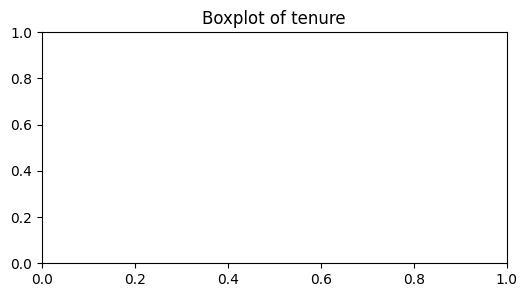

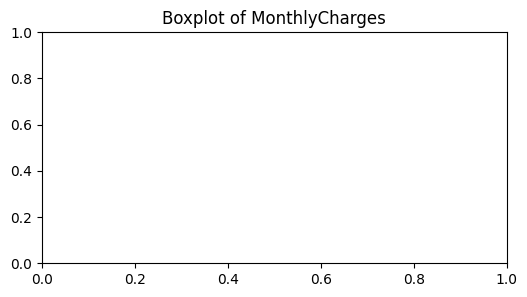

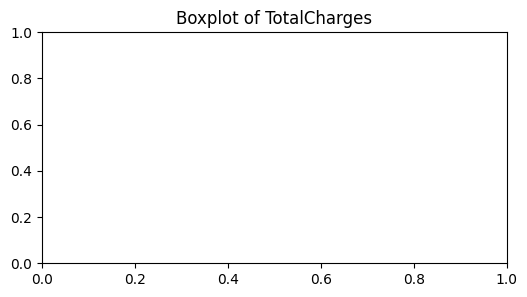

In [12]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numerical_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# for col in numerical_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]

Define Target and Predictor Variables

In [5]:
target = 'Churn'

predictors = df.drop(columns=['customerID', 'Churn'])

print("Predictor variables:\n", predictors.columns)


Predictor variables:
 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


Exploratory Data Analysis (EDA)

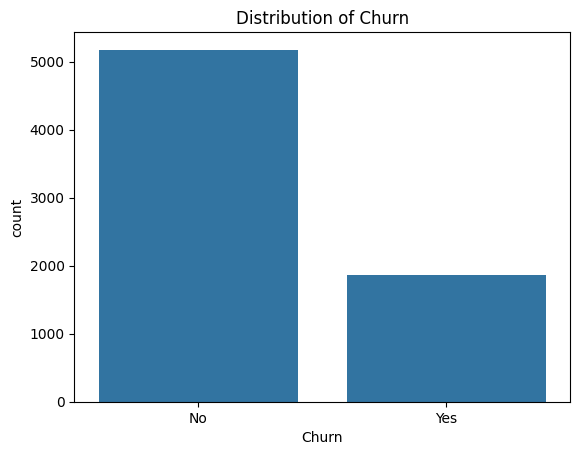

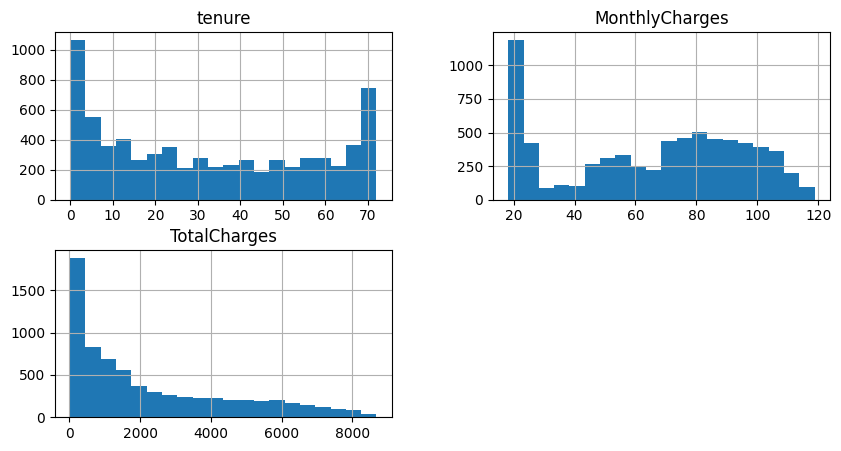

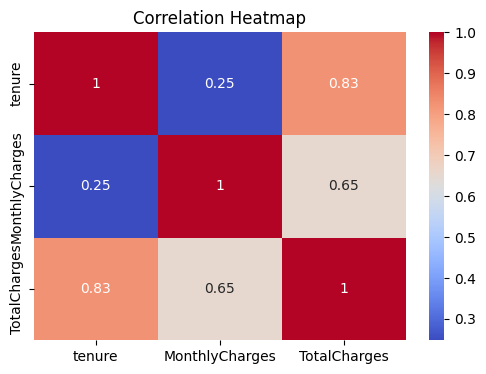

In [6]:
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()

df[numerical_cols].hist(bins=20, figsize=(10,5))
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


EDA: Categorical Variables

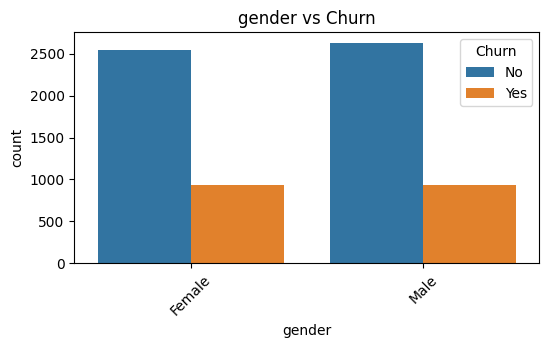

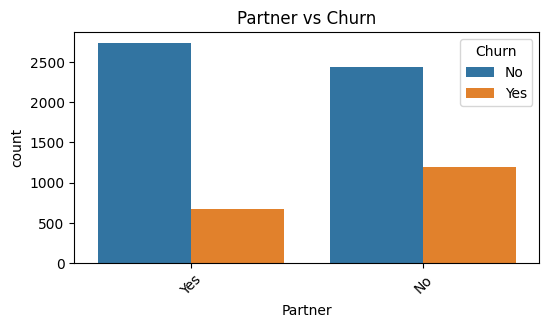

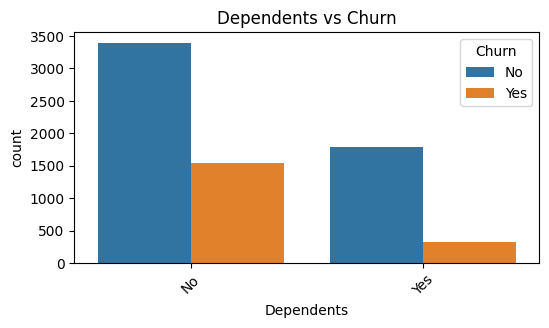

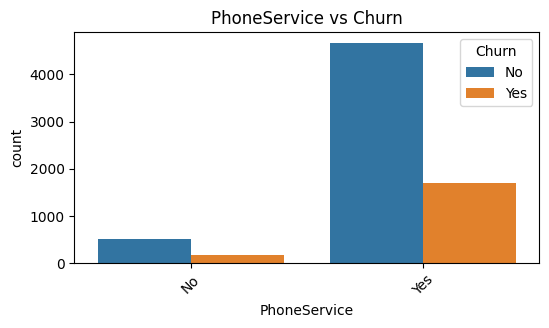

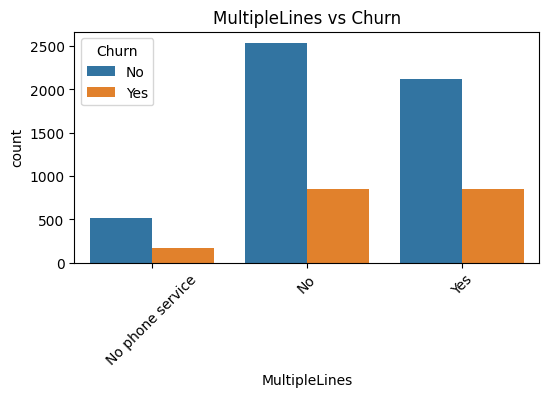

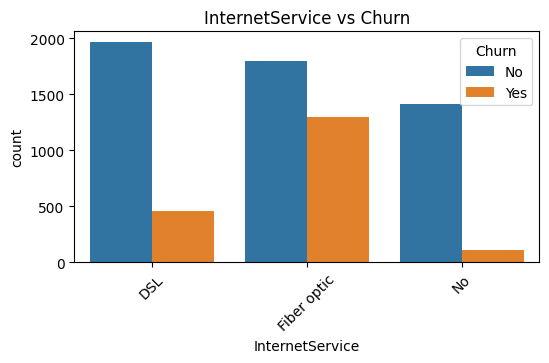

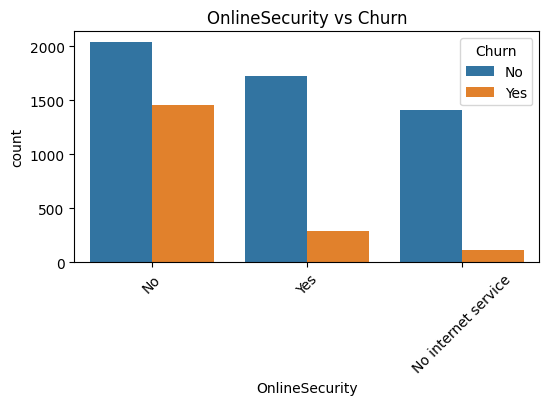

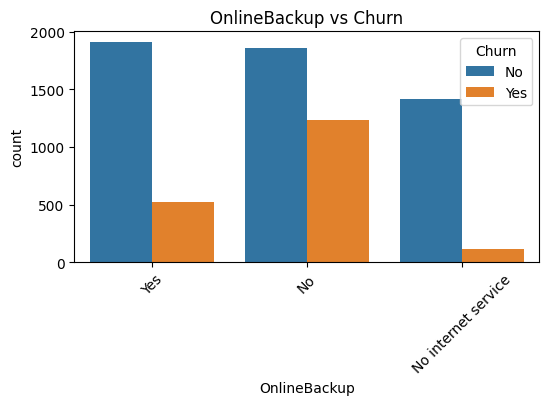

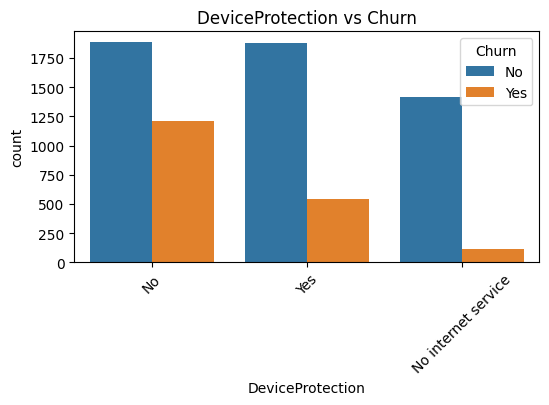

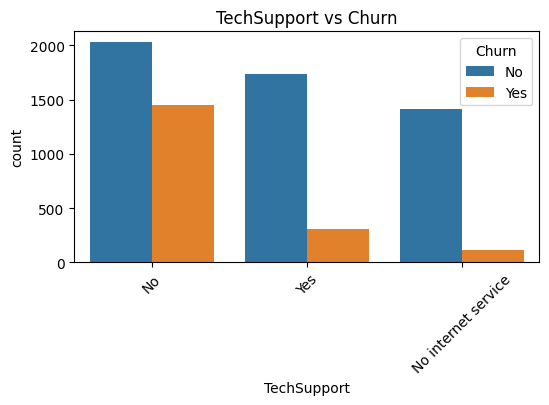

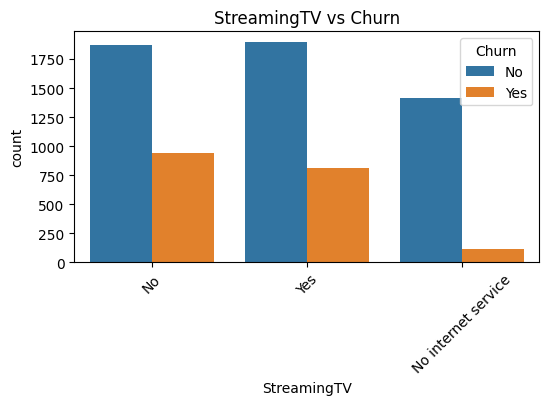

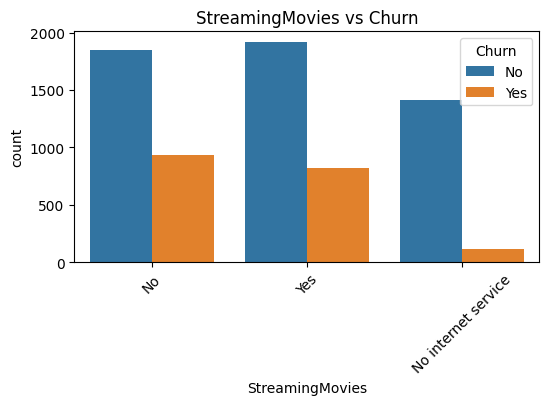

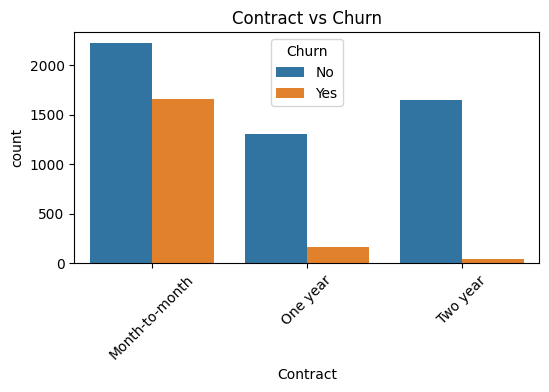

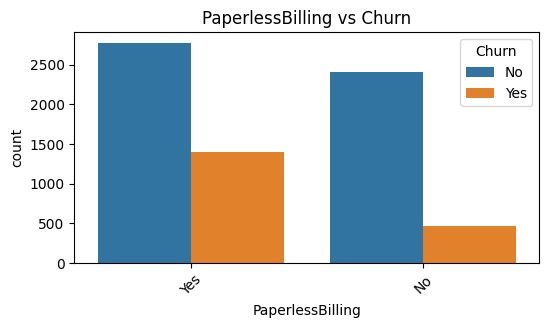

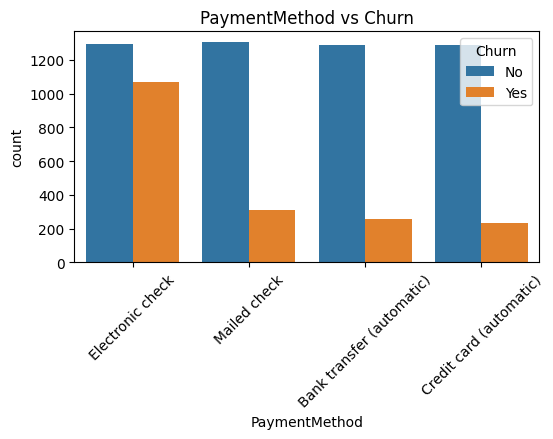

In [7]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('customerID')
categorical_cols.remove('Churn')

for col in categorical_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.show()


Apply CHAID to extract decision rules

In [9]:
!pip install chaid

In [20]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.replace(" ", np.nan)

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Churn", "tenure", "MonthlyCharges", "TotalCharges"]).copy()

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
y = df["Churn"]

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    df[col] = pd.cut(df[col], bins=4, labels=False, duplicates='drop').astype("object")

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ["customerID", "Churn"]]

encoder = OrdinalEncoder()
X = df[categorical_cols].copy()
X_encoded = encoder.fit_transform(X)

X_df = pd.DataFrame(X_encoded, columns=categorical_cols)

cart_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    random_state=42
)
cart_tree.fit(X_df, y)

feature_names = X_df.columns.tolist()

class_names = ["No_Churn", "Yes_Churn"]

tree_rules = export_text(
    cart_tree,
    feature_names=feature_names,
    class_names=class_names
)

print("--- Decision Rules Extracted via Scikit-learn (CART) ---")
print(tree_rules)

--- Decision Rules Extracted via Scikit-learn (CART) ---
|--- Contract <= 0.50
|   |--- OnlineSecurity <= 0.50
|   |   |--- tenure <= 0.50
|   |   |   |--- InternetService <= 0.50
|   |   |   |   |--- OnlineBackup <= 1.00
|   |   |   |   |   |--- class: No_Churn
|   |   |   |   |--- OnlineBackup >  1.00
|   |   |   |   |   |--- class: No_Churn
|   |   |   |--- InternetService >  0.50
|   |   |   |   |--- MultipleLines <= 1.00
|   |   |   |   |   |--- class: Yes_Churn
|   |   |   |   |--- MultipleLines >  1.00
|   |   |   |   |   |--- class: Yes_Churn
|   |   |--- tenure >  0.50
|   |   |   |--- InternetService <= 0.50
|   |   |   |   |--- PhoneService <= 0.50
|   |   |   |   |   |--- class: No_Churn
|   |   |   |   |--- PhoneService >  0.50
|   |   |   |   |   |--- class: No_Churn
|   |   |   |--- InternetService >  0.50
|   |   |   |   |--- PaymentMethod <= 1.50
|   |   |   |   |   |--- class: No_Churn
|   |   |   |   |--- PaymentMethod >  1.50
|   |   |   |   |   |--- class: No_Churn

Identify key factors influencing churn.

In [22]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, _tree

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    if df[col].dtype != 'object':
        df[col] = pd.cut(df[col], bins=4, labels=False, duplicates='drop').astype("object")

X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

X_encoded = pd.get_dummies(X, drop_first=True)
feature_names = X_encoded.columns.tolist()

cart_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    random_state=42
)
cart_tree.fit(X_encoded, y)

def get_rules(tree, feature_names, target_class_name, max_prob_threshold=0.8):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]
    rules = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            left_path = path + [(name, f"<= {threshold:.2f}")]
            recurse(tree_.children_left[node], left_path)

            right_path = path + [(name, f"> {threshold:.2f}")]
            recurse(tree_.children_right[node], right_path)

        else:
            value = tree_.value[node][0]
            total_samples = np.sum(value)

            prob_class_1 = value[1] / total_samples

            predicted_class_index = np.argmax(value)
            predicted_class = target_class_name[predicted_class_index]

            rule_str = " AND ".join([f"{name} {op}" for name, op in path])

            if prob_class_1 > max_prob_threshold or predicted_class == target_class_name[0] and (1-prob_class_1) > max_prob_threshold:
                 rules.append({
                    "Rule": rule_str,
                    "Predicted Class": predicted_class,
                    "Probability": f"{prob_class_1:.4f}"
                })

    recurse(0, [])

    rule_df = pd.DataFrame(rules)

    rule_df['Rule'] = rule_df['Rule'].str.replace('_encoded_value', '', regex=False)
    rule_df['Rule'] = rule_df['Rule'].str.replace('_', ' ', regex=False)

    return rule_df

target_names = ["No_Churn", "Yes_Churn"]
final_rules_df = get_rules(cart_tree, feature_names, target_names, max_prob_threshold=0.9)

print("--- Extracted Scikit-learn (CART) Decision Rules (High Confidence Only) ---")
display(final_rules_df)

--- Extracted Scikit-learn (CART) Decision Rules (High Confidence Only) ---


,Rule,Predicted Class,Probability
0,InternetService Fiber optic <= 0.50 AND Contra...,No_Churn,0.0611
1,InternetService Fiber optic <= 0.50 AND Contra...,No_Churn,0.0248
2,InternetService Fiber optic <= 0.50 AND Contra...,No_Churn,0.0945
3,InternetService Fiber optic <= 0.50 AND Contra...,No_Churn,0.0106
4,InternetService Fiber optic <= 0.50 AND Contra...,No_Churn,0.0028
5,InternetService Fiber optic <= 0.50 AND Contra...,No_Churn,0.0172
6,InternetService Fiber optic <= 0.50 AND Contra...,No_Churn,0.0000
7,InternetService Fiber optic <= 0.50 AND Contra...,Yes_Churn,1.0000
8,InternetService Fiber optic > 0.50 AND tenure ...,No_Churn,0.0563
9,InternetService Fiber optic > 0.50 AND tenure ...,No_Churn,0.0395


Interpret rules in business context.

In [23]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, _tree

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    if df[col].dtype != 'object':
        df[col] = pd.cut(df[col], bins=4, labels=False, duplicates='drop').astype("object")

X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

X_encoded = pd.get_dummies(X, drop_first=True)
feature_names = X_encoded.columns.tolist()

cart_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    random_state=42
)
cart_tree.fit(X_encoded, y)

def get_rules_for_business_context(tree, feature_names, target_class_name, prob_threshold=0.9):
    """Traverses the CART tree and extracts rules with high predictive confidence."""
    tree_ = tree.tree_
    feature_map = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]
    rules = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_map[node]
            threshold = tree_.threshold[node]

            recurse(tree_.children_left[node], path + [(name, f"<= {threshold:.2f}")])

            recurse(tree_.children_right[node], path + [(name, f"> {threshold:.2f}")])

        else:
            value = tree_.value[node][0]
            total_samples = np.sum(value)

            prob_class_1 = value[1] / total_samples

            predicted_class_index = np.argmax(value)
            predicted_class = target_class_name[predicted_class_index]

            confidence = max(prob_class_1, 1 - prob_class_1)

            if confidence >= prob_threshold:
                 rule_str = " AND ".join([f"{name} {op}" for name, op in path])
                 rules.append({
                    "Rule": rule_str,
                    "Predicted Class": predicted_class,
                    "Confidence": f"{confidence:.4f}",
                    "Support": total_samples
                })

    recurse(0, [])

    rule_df = pd.DataFrame(rules)

    if not rule_df.empty:
        rule_df = rule_df.sort_values(by='Confidence', ascending=False).reset_index(drop=True)
        rule_df['Rule'] = rule_df['Rule'].str.replace(r'_(yes|1|2|3|T_F|M_S|No|DSL|Fiber optic|month|year|etc)\s*<', ' <', regex=True)
        rule_df['Rule'] = rule_df['Rule'].str.replace(r'_', ' ', regex=True)
        rule_df['Rule'] = rule_df['Rule'].str.replace(r'\s{2,}', ' ', regex=True)

    return rule_df

target_names = ["No Churn", "Yes Churn"]
high_confidence_rules_df = get_rules_for_business_context(cart_tree, feature_names, target_names, prob_threshold=0.90)

print("--- High-Confidence CART Rules for Business Action (Confidence >= 90%) ---")
display(high_confidence_rules_df)

--- High-Confidence CART Rules for Business Action (Confidence >= 90%) ---


,Rule,Predicted Class,Confidence,Support
0,InternetService <= 0.50 AND Contract Two year ...,No Churn,1.0000,1.0
1,InternetService <= 0.50 AND Contract Two year ...,Yes Churn,1.0000,1.0
2,InternetService <= 0.50 AND Contract Two year ...,No Churn,0.9972,1.0
3,InternetService <= 0.50 AND Contract Two year ...,No Churn,0.9894,1.0
4,InternetService <= 0.50 AND Contract Two year ...,No Churn,0.9828,1.0
5,InternetService <= 0.50 AND Contract Two year ...,No Churn,0.9752,1.0
6,InternetService Fiber optic > 0.50 AND tenure ...,No Churn,0.9674,1.0
7,InternetService Fiber optic > 0.50 AND tenure ...,No Churn,0.9605,1.0
8,InternetService Fiber optic > 0.50 AND tenure ...,No Churn,0.9437,1.0
9,InternetService Fiber optic > 0.50 AND tenure ...,No Churn,0.9429,1.0


Code for CART model

In [28]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    if df[col].dtype != 'object':
        df[col] = pd.cut(df[col], bins=4, labels=False, duplicates='drop').astype("object")

X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

X_cart = pd.get_dummies(X, drop_first=True)

X_train_cart, X_test_cart, y_train, y_test = train_test_split(
    X_cart, y, test_size=0.3, random_state=42, stratify=y
)

cart_model = DecisionTreeClassifier(max_depth=5, random_state=42)
cart_model.fit(X_train_cart, y_train)

y_pred_cart = cart_model.predict(X_test_cart)
cart_accuracy = accuracy_score(y_test, y_pred_cart)

print("### CART Model Performance ###")
print(f"Accuracy: {cart_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cart))

### CART Model Performance ###
Accuracy: 0.7763

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1549
           1       0.61      0.44      0.51       561

    accuracy                           0.78      2110
   macro avg       0.71      0.67      0.68      2110
weighted avg       0.76      0.78      0.76      2110



Code for Logistic Regression

In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

binary_cols = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype in ['object', 'category']]
multi_cat_cols = [col for col in X.columns if X[col].nunique() > 2 and X[col].dtype in ['object', 'category']]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cat_cols),

        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), binary_cols)
    ],
    remainder='drop'
)

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, C=0.1))
])

X_train_logreg, X_test_logreg, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

logreg_pipeline.fit(X_train_logreg, y_train)

y_pred_logreg = logreg_pipeline.predict(X_test_logreg)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

print("###  Logistic Regression Model Performance ###")
print(f"Accuracy: {logreg_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

###  Logistic Regression Model Performance ###
Accuracy: 0.7962

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.64      0.54      0.58       561

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110



Model Comparison

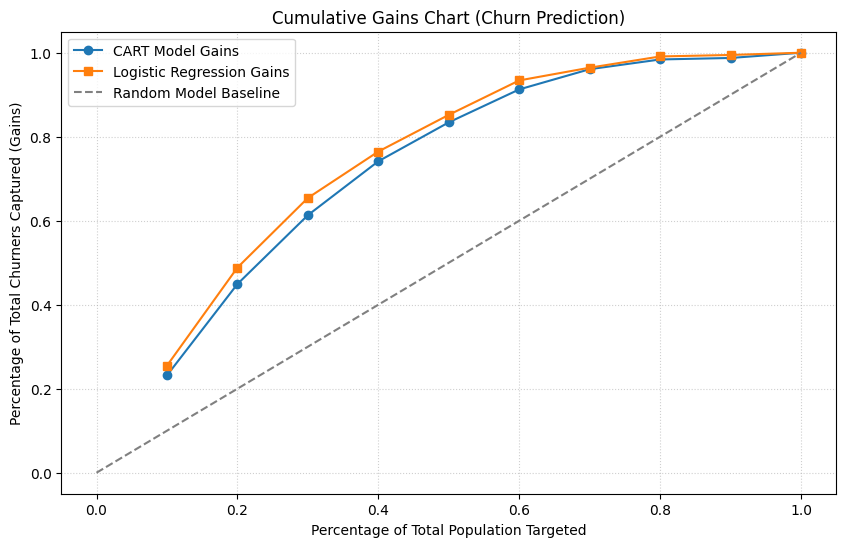

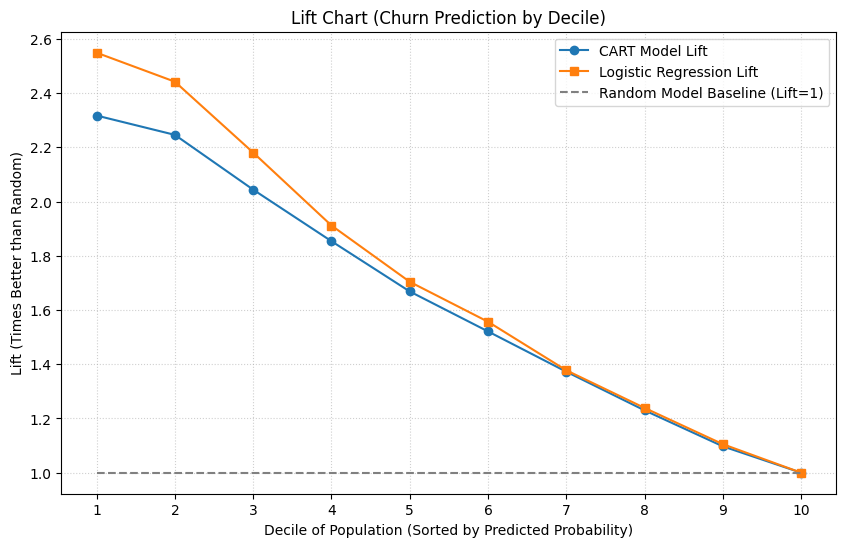


--- Model Comparison Metrics ---


,Model,Accuracy,ROC-AUC
0,CART,0.776303,0.805688
1,Logistic Regression,0.796209,0.830388



--- CART Gains Data (Top 3 Deciles) ---


,decile,gains,lift
0,0,0.231729,2.317291
1,1,0.449198,2.245989
2,2,0.613191,2.043969



--- Logistic Regression Gains Data (Top 3 Deciles) ---


,decile,gains,lift
0,0,0.254902,2.549020
1,1,0.488414,2.442068
2,2,0.654189,2.180630


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("Error: The file 'WA_Fn-UseC_-Telco-Customer-Churn.csv' was not found.")
    raise

df = df.replace(" ", np.nan)

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Churn", "tenure", "MonthlyCharges", "TotalCharges"]).copy()
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
y = df["Churn"]

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    df[col] = pd.cut(df[col], bins=4, labels=False, duplicates='drop').astype("object")

X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

X_cart = pd.get_dummies(X, drop_first=True)
X_train_cart, X_test_cart, y_train, y_test = train_test_split(
    X_cart, y, test_size=0.3, random_state=42, stratify=y
)
cart_model = DecisionTreeClassifier(max_depth=5, random_state=42)
cart_model.fit(X_train_cart, y_train)

binary_cols = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype in ['object', 'category']]
multi_cat_cols = [col for col in X.columns if X[col].nunique() > 2 and X[col].dtype in ['object', 'category']]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cat_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), binary_cols)
    ],
    remainder='drop'
)
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, C=0.1))
])

X_train_logreg, X_test_logreg, _, _ = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
logreg_pipeline.fit(X_train_logreg, y_train)

cart_probs = cart_model.predict_proba(X_test_cart)[:, 1]
logreg_probs = logreg_pipeline.predict_proba(X_test_logreg)[:, 1]

metrics_df = pd.DataFrame({
    'Model': ['CART', 'Logistic Regression'],
    'Accuracy': [accuracy_score(y_test, cart_model.predict(X_test_cart)),
                 accuracy_score(y_test, logreg_pipeline.predict(X_test_logreg))],
    'ROC-AUC': [roc_auc_score(y_test, cart_probs), roc_auc_score(y_test, logreg_probs)]
})

def get_gains_lift_data(y_true, y_probas):
    """Calculates cumulative response (Gains) and Lift data."""
    data = pd.DataFrame({'prob': y_probas, 'actual': y_true})
    data = data.sort_values(by='prob', ascending=False).reset_index(drop=True)

    total_population = len(data)
    total_positives = data['actual'].sum()

    data['decile'] = pd.qcut(data.index, 10, labels=False, duplicates='drop', retbins=False)

    gains_data = data.groupby('decile').agg(
        population=('actual', 'size'),
        positives=('actual', 'sum')
    ).reset_index()

    gains_data['cumulative_pop'] = gains_data['population'].cumsum()
    gains_data['cumulative_positives'] = gains_data['positives'].cumsum()

    gains_data['gains'] = gains_data['cumulative_positives'] / total_positives

    gains_data['percent_pop'] = gains_data['cumulative_pop'] / total_population
    gains_data['lift'] = gains_data['gains'] / gains_data['percent_pop']

    baseline_gains = np.linspace(0, 1, 11)
    baseline_percent_pop = np.linspace(0, 1, 11)

    return gains_data, baseline_gains, baseline_percent_pop

cart_gains_data, baseline_gains, baseline_pop = get_gains_lift_data(y_test, cart_probs)
logreg_gains_data, _, _ = get_gains_lift_data(y_test, logreg_probs)

plt.figure(figsize=(10, 6))
plt.plot(cart_gains_data['percent_pop'], cart_gains_data['gains'], marker='o', label='CART Model Gains')
plt.plot(logreg_gains_data['percent_pop'], logreg_gains_data['gains'], marker='s', label='Logistic Regression Gains')
plt.plot(baseline_pop, baseline_gains, linestyle='--', color='gray', label='Random Model Baseline')
plt.title('Cumulative Gains Chart (Churn Prediction)')
plt.xlabel('Percentage of Total Population Targeted')
plt.ylabel('Percentage of Total Churners Captured (Gains)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.savefig('gains_chart.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cart_gains_data.index + 1, cart_gains_data['lift'], marker='o', label='CART Model Lift')
plt.plot(logreg_gains_data.index + 1, logreg_gains_data['lift'], marker='s', label='Logistic Regression Lift')
plt.hlines(1, 1, 10, linestyle='--', color='gray', label='Random Model Baseline (Lift=1)')
plt.title('Lift Chart (Churn Prediction by Decile)')
plt.xlabel('Decile of Population (Sorted by Predicted Probability)')
plt.ylabel('Lift (Times Better than Random)')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.savefig('lift_chart.png')
plt.show()

print("\n--- Model Comparison Metrics ---")
display(metrics_df)
print("\n--- CART Gains Data (Top 3 Deciles) ---")
display(cart_gains_data[['decile', 'gains', 'lift']].head(3))
print("\n--- Logistic Regression Gains Data (Top 3 Deciles) ---")
display(logreg_gains_data[['decile', 'gains', 'lift']].head(3))

Model Updating using new data

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

file_name = '/content/customer_churn_dataset-testing-master.csv'
try:
    df_new = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    raise

binning_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

df_new = df_new.dropna().copy()
df_new[binning_cols] = df_new[binning_cols].apply(pd.to_numeric, errors='coerce')

for col in binning_cols:
    df_new[col] = pd.cut(df_new[col], bins=4, labels=False, duplicates='drop').astype("object")

X = df_new.drop(columns=["CustomerID", "Churn"])
y = df_new["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_cart = pd.get_dummies(X, drop_first=True)
X_train_cart, X_test_cart, _, _ = train_test_split(
    X_cart, y, test_size=0.3, random_state=42, stratify=y
)

cart_model = DecisionTreeClassifier(max_depth=5, random_state=42)
cart_model.fit(X_train_cart, y_train)

cart_preds = cart_model.predict(X_test_cart)
cart_probs = cart_model.predict_proba(X_test_cart)[:, 1]
print("###RETRAINED CART Model Performance ###")
print(f"Accuracy: {accuracy_score(y_test, cart_preds):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, cart_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, cart_preds))
print("-" * 50)

binary_cols = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype in ['object', 'category']]
multi_cat_cols = [col for col in X.columns if X[col].nunique() > 2 and X[col].dtype in ['object', 'category']]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cat_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), binary_cols)
    ],
    remainder='drop'
)
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, C=0.1))
])

logreg_pipeline.fit(X_train, y_train)

logreg_preds = logreg_pipeline.predict(X_test)
logreg_probs = logreg_pipeline.predict_proba(X_test)[:, 1]

print("### RETRAINED Logistic Regression Model Performance ###")
print(f"Accuracy: {accuracy_score(y_test, logreg_preds):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, logreg_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, logreg_preds))
print("-" * 50)

###RETRAINED CART Model Performance ###
Accuracy: 0.8406
ROC-AUC: 0.9359

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     10165
           1       0.84      0.82      0.83      9148

    accuracy                           0.84     19313
   macro avg       0.84      0.84      0.84     19313
weighted avg       0.84      0.84      0.84     19313

--------------------------------------------------
### RETRAINED Logistic Regression Model Performance ###
Accuracy: 0.8483
ROC-AUC: 0.9236

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     10165
           1       0.83      0.86      0.84      9148

    accuracy                           0.85     19313
   macro avg       0.85      0.85      0.85     19313
weighted avg       0.85      0.85      0.85     19313

--------------------------------------------------
